# Importing Important Library

In [ ]:
import tensorflow.keras.backend as K 

from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.layers import Activation, Add,DepthwiseConv2D, BatchNormalization, Concatenate, Conv2D, Dense,Dropout, GlobalAveragePooling2D, GlobalMaxPooling2D, Input, Lambda,LeakyReLU, MaxPooling2D, Multiply, Permute, Reshape, UpSampling2D 
import collections
import tensorflow as tf
from tensorflow.keras import regularizers
from  tensorflow.keras.initializers import *
# from keras_flops import get_flops

In [ ]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])
    except RuntimeError as e:
        print(e)

#Reading Data

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_path = 'D:/chanchal_NITK/KMC Dataset for grading/Training/'
val_path = 'D:/chanchal_NITK/KMC Dataset for grading/Validation/'
test_path = 'D:/chanchal_NITK/KMC Dataset for grading/Test/'
batch_size = 4
img_height = 224
img_width = 224
no_of_classes = 5
classes_name = [0,1,2,3,4]
input_shape = (img_height , img_width , 3)


random_seed = np.random.seed(1142)

datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    horizontal_flip = False,
    vertical_flip = False,
    #validation_split = 0.1,
    featurewise_std_normalization=True)

train_generator = datagen.flow_from_directory(
    train_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle = True,
    class_mode='categorical')

validation_generator = datagen.flow_from_directory(
    val_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle = True,
    class_mode='categorical')


print(train_generator.class_indices)

Found 3432 images belonging to 5 classes.
Found 503 images belonging to 5 classes.
{'grade0': 0, 'grade1': 1, 'grade2': 2, 'grade3': 3, 'grade4': 4}


#Proposed CNN Architecture

In [ ]:
def inception_block(input,fil):
  conv1 = tf.keras.layers.Conv2D(filters = fil/4, kernel_size = (1,1), strides = (1,1), padding='same')(input)
  conv1 = tf.keras.layers.BatchNormalization()(conv1)
  conv1 = tf.keras.layers.Activation('relu')(conv1)

  conv2 = tf.keras.layers.Conv2D(filters = fil/4, kernel_size = (1,1), strides = (1,1), padding='same')(input)
  conv2 = tf.keras.layers.BatchNormalization()(conv2)
  conv2 = tf.keras.layers.Activation('relu')(conv2)
  conv2 = tf.keras.layers.Conv2D(filters = fil/4, kernel_size = (3,3), strides = (1,1), padding='same')(conv2)
  conv2 = tf.keras.layers.BatchNormalization()(conv2)
  conv2 = tf.keras.layers.Activation('relu')(conv2)

  conv3 = tf.keras.layers.Conv2D(filters = fil/4, kernel_size = (1,1), strides = (1,1), padding='same')(input)
  conv3 = tf.keras.layers.BatchNormalization()(conv3)
  conv3 = tf.keras.layers.Activation('relu')(conv3)
  conv3 = tf.keras.layers.Conv2D(filters = fil/4, kernel_size = (5,5), strides = (1,1), padding='same')(conv3)
  conv3 = tf.keras.layers.BatchNormalization()(conv3)
  conv3 = tf.keras.layers.Activation('relu')(conv3)

  conv4 = tf.keras.layers.MaxPooling2D(pool_size = (3,3),strides = (1,1),padding = 'same')(input)
  conv4 = tf.keras.layers.Conv2D(filters = fil/4, kernel_size = [1,1], strides = (1,1), padding='same')(conv4)
  conv4 = tf.keras.layers.BatchNormalization()(conv4)
  conv4 = tf.keras.layers.Activation('relu')(conv4)

  concat = tf.keras.layers.Concatenate()([conv1,conv2,conv3,conv4])
  output = tf.keras.layers.Add()([concat,input])
  return output







def se_block(block_input, num_filters, ratio=8):

	pool1 = tf.keras.layers.GlobalAveragePooling2D()(block_input)
	flat = tf.keras.layers.Reshape((1, 1, num_filters))(pool1)
	dense1 = tf.keras.layers.Dense(num_filters//ratio, activation='relu')(flat)
	dense2 = tf.keras.layers.Dense(num_filters, activation='sigmoid')(dense1)
	scale = tf.keras.layers.multiply([block_input, dense2])
	
	return scale

def resnet_block(block_input, num_filters):

  if tf.keras.backend.int_shape(block_input)[3] != num_filters:
  	block_input = tf.keras.layers.Conv2D(num_filters, kernel_size=(1, 1))(block_input)
	
  x = inception_block(block_input, num_filters)
  x = inception_block(x, num_filters)

  se = se_block(x, num_filters=num_filters)
	
  sum = tf.keras.layers.Add()([block_input, se])
  relu2 = tf.keras.layers.Activation('relu')(sum)
	
  return relu2

def se_resnet14():

  input = tf.keras.layers.Input(shape=(224, 224, 3))
  conv1 = tf.keras.layers.Conv2D(16, kernel_size=(7, 7), activation='relu', padding='same', kernel_initializer='he_normal')(input)

  block1 = resnet_block(conv1, 16)
  block1 = inception_block(block1,16)
  block2 = resnet_block(block1, 16)
  block2 = inception_block(block2,16)
  block3 = resnet_block(block2,16)
  block3 = inception_block(block3,16)

  pool1 = tf.keras.layers.MaxPooling2D((3, 3), (2,2), padding = 'same')(block3)
	
  block4 = resnet_block(pool1, 32)
  block4 = inception_block(block4,32)
  block5 = resnet_block(block4, 32)
  block5 = inception_block(block5,32)
  block6 = resnet_block(block5,32)
  block6 = inception_block(block6,32)

  pool2 = tf.keras.layers.MaxPooling2D((3, 3), (2,2), padding = 'same')(block6)

  block7 = resnet_block(pool2, 64)
  block7 = inception_block(block7,64)
  block8 = resnet_block(block7, 64)
  block8 = inception_block(block8,64)
  block9 = resnet_block(block8,64)	
  block9 = inception_block(block9,64)

  pool3 = tf.keras.layers.MaxPooling2D((3, 3), (2,2), padding = 'same')(block9)


  ginp1 = UpSampling2D(size=(2, 2), interpolation='bilinear')(pool1)
  ginp2 = UpSampling2D(size=(4, 4), interpolation='bilinear')(pool2)
  ginp3 = UpSampling2D(size=(8, 8), interpolation='bilinear')(pool3)

  hypercolumn = Concatenate()([ginp1, ginp2, ginp3]) 
  global_pool = tf.keras.layers.GlobalAveragePooling2D()(hypercolumn)

  x = tf.keras.layers.Dense(128, activation = 'relu')(global_pool)
  x = tf.keras.layers.Dropout(0.3)(x)

  output = tf.keras.layers.Dense(no_of_classes, activation='softmax')(x)
	
  model = tf.keras.models.Model(inputs=input, outputs=output)
  return model


model_prop = se_resnet14()

for layer in model_prop.layers:
    if hasattr(layer, 'kernel_regularizer'):
        layer.kernel_regularizer= regularizers.l2(0.003)
    
    if hasattr(layer, 'bias_regularizer'):
        layer.bias_regularizer= regularizers.l2(0.003)

model_prop.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ["acc"])
model_prop.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_165 (Conv2D)             (None, 224, 224, 16) 2368        input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_167 (Conv2D)             (None, 224, 224, 4)  68          conv2d_165[0][0]                 
__________________________________________________________________________________________________
conv2d_169 (Conv2D)             (None, 224, 224, 4)  68          conv2d_165[0][0]                 
____________________________________________________________________________________________

#Training

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_acc' , mode='max' ,
                                                  factor = 0.5 , patience = 5 , verbose=1 , cooldown = 1,
                                                 min_delta = 0.0001)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=0.0001, patience=40, verbose=1,
                                              mode = 'max', restore_best_weights = True)
check_path = 'D:/chanchal_NITK/TAI_Data/proposed/TAIP_maint1.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(check_path, monitor = 'val_acc', verbose=1, save_best_only=True, save_weights_only=True, mode='max')


history = model_prop.fit_generator(train_generator , validation_data = validation_generator ,
                                  steps_per_epoch= len(train_generator) ,
                                  validation_steps = len(validation_generator)
                                  ,epochs = 75,callbacks = [reduce_lr, early_stop, checkpoint] )
# model_prop.load_weights('/content/drive/MyDrive/Major_project_data/Kidney_KMC/KMC_kidney_40x_dataset/Metrics/checkpoint_anirudh_7.h5')

C:\Users\NITK\anaconda3\envs\Shyamlalnitk\lib\site-packages\tensorflow\python\keras\engine\training.py:1963: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
C:\Users\NITK\AppData\Roaming\Python\Python39\site-packages\keras_preprocessing\image\image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\NITK\AppData\Roaming\Python\Python39\site-packages\keras_preprocessing\image\image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/75
861/861 [==============================] - 309s 328ms/step - loss: 2.2692 - acc: 0.3727 - val_loss: 1.1080 - val_acc: 0.4095

Epoch 00001: val_acc improved from -inf to 0.40954, saving model to D:/chanchal_NITK/TAI_Data/proposed\TAIP_maint1.h5
Epoch 2/75
861/861 [==============================] - 280s 325ms/step - loss: 1.1804 - acc: 0.5032 - val_loss: 10.1192 - val_acc: 0.2087

Epoch 00002: val_acc did not improve from 0.40954
Epoch 3/75
861/861 [==============================] - 281s 326ms/step - loss: 1.1207 - acc: 0.5232 - val_loss: 0.9166 - val_acc: 0.6839

Epoch 00003: val_acc improved from 0.40954 to 0.68390, saving model to D:/chanchal_NITK/TAI_Data/proposed\TAIP_maint1.h5
Epoch 4/75
861/861 [==============================] - 277s 322ms/step - loss: 1.0099 - acc: 0.5689 - val_loss: 8.6467 - val_acc: 0.2445

Epoch 00004: val_acc did not improve from 0.68390
Epoch 5/75
861/861 [==============================] - 279s 324ms/step - loss: 0.9425 - acc: 0.5851 - val_loss: 3

In [ ]:
np.save('D:/chanchal_NITK/TAI_Data/proposed/TAIP_maint1.npy',history.history)

In [ ]:
a=np.load('D:/chanchal_NITK/TAI_Data/proposed/KMC/TAIP_maint1.npy',allow_pickle='TRUE').item()

In [ ]:
model_prop.load_weights('D:/chanchal_NITK/TAI_Data/proposed/KMC/TAIP_maint1.h5')

#Learning Curves

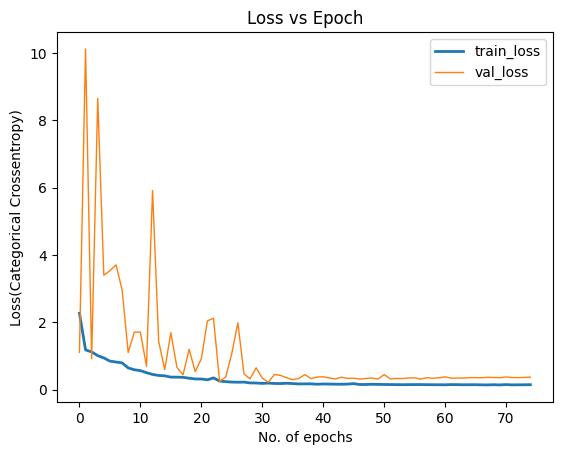

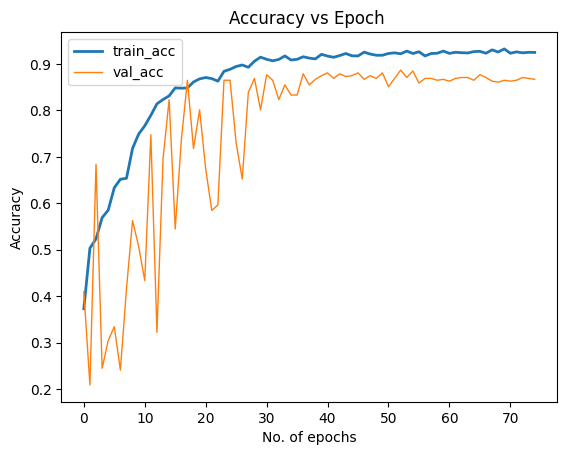

In [ ]:
import matplotlib.pyplot as plt
plt.plot(a['loss'] , label = 'train_loss',linewidth=2)
plt.plot(a['val_loss'] , label = 'val_loss',linewidth=1)
plt.legend()
plt.xlabel("No. of epochs")
plt.ylabel("Loss(Categorical Crossentropy)")
plt.title("Loss vs Epoch")
plt.savefig('D:/chanchal_NITK/TAI_Data/plot/KMC/proposed_Loss.png',bbox_inches='tight')
plt.show()
plt.plot(a['acc'] , label = 'train_acc',linewidth=2)
plt.plot(a['val_acc'] , label = 'val_acc',linewidth=1)
plt.legend()
plt.xlabel("No. of epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epoch ")
plt.savefig('D:/chanchal_NITK/TAI_Data/plot/KMC/proposed-ACC.png',bbox_inches='tight')
plt.show()

#Prediction

In [ ]:
test_d = ImageDataGenerator(rescale=1. / 255)
test = test_d.flow_from_directory(
    'D:/chanchal_NITK/KMC Dataset for grading/Test/',
    target_size=(224,224),
    batch_size=1,
    shuffle = False,
    class_mode='categorical')

Found 142 images belonging to 5 classes.


In [ ]:
import numpy as np
test_step = test.n//test.batch_size
test.reset()
pred = model_prop.predict_generator(test , steps = test_step , verbose = 1)
pred_class_indices = np.argmax(pred,axis=1)

## printing predicted labels
print(pred_class_indices)

142/142 [==============================] - 25s 147ms/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 2 1 1 1 1 1 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 3 3 0 1 3 3 3 3 2 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 3 3 4 4 4 4 4 4]


#Performance Measures

In [ ]:
from sklearn.metrics import *
from sklearn.metrics import confusion_matrix, cohen_kappa_score
classes = [0,1,2,3,4]


for cl in classes:

    print("class: ",cl)

    a1 = np.uint8(test.labels == cl)
    a2 = np.uint8(pred_class_indices == cl)

    print('Accuracy {}'.format(accuracy_score(y_true=a1, y_pred=a2)))
    print('F1 {}'.format(f1_score(y_true=a1, y_pred=a2)))
    print('precision {}'.format(precision_score(y_true=a1, y_pred=a2)))
    print('recall {}'.format(recall_score(y_true=a1, y_pred=a2)))
    print('jaccard {}'.format(jaccard_score(y_true=a1, y_pred=a2)))
    print('matthews {}'.format(matthews_corrcoef(y_true=a1, y_pred=a2)))
    print('roc_auc {}'.format(roc_auc_score(a1, a2)))
    print('kappa {}'.format(cohen_kappa_score(a1,a2)))
    print("_______________________________")

class:  0
Accuracy 0.9859154929577465
F1 0.975609756097561
precision 0.975609756097561
recall 0.975609756097561
jaccard 0.9523809523809523
matthews 0.965708765998551
roc_auc 0.9828543829992755
kappa 0.965708765998551
_______________________________
class:  1
Accuracy 0.971830985915493
F1 0.9259259259259259
precision 0.9259259259259259
recall 0.9259259259259259
jaccard 0.8620689655172413
matthews 0.9085346215780998
roc_auc 0.95426731078905
kappa 0.9085346215780998
_______________________________
class:  2
Accuracy 0.9507042253521126
F1 0.8510638297872342
precision 0.9090909090909091
recall 0.8
jaccard 0.7407407407407407
matthews 0.824082295108704
roc_auc 0.8914529914529914
kappa 0.8216720487979907
_______________________________
class:  3
Accuracy 0.9507042253521126
F1 0.8510638297872339
precision 0.7692307692307693
recall 0.9523809523809523
jaccard 0.7407407407407407
matthews 0.8286581621415154
roc_auc 0.9513970877607241
kappa 0.821927624507345
_______________________________
class:  4

In [ ]:
print('Accuracy {}'.format(accuracy_score(y_true=test.labels, y_pred=pred_class_indices)))
print('F1 {}'.format(f1_score(y_true=test.labels, y_pred=pred_class_indices,average = "macro")))
print('precision {}'.format(precision_score(y_true=test.labels, y_pred=pred_class_indices,average = "macro")))
print('recall {}'.format(recall_score(y_true=test.labels, y_pred=pred_class_indices,average = "macro")))

print('jaccard {}'.format(jaccard_score(y_true=test.labels, y_pred=pred_class_indices,average = "macro")))
print('matthews {}'.format(matthews_corrcoef(y_true=test.labels, y_pred=pred_class_indices)))
print('kappa {}'.format(cohen_kappa_score(test.labels, pred_class_indices)))
print('Roc_Auc {}'.format(roc_auc_score(y_true=test.labels, y_score=pred,multi_class="ovo", average="macro")))
print('confusion_matrix\n {}'.format(confusion_matrix(y_true=test.labels, y_pred=pred_class_indices)))
print('classification_report\n {}'.format(classification_report(y_true=test.labels, y_pred=pred_class_indices)))
print('\n\n')

Accuracy 0.9154929577464789
F1 0.9059178535047762
precision 0.9082791643767253
recall 0.9093547554523166
jaccard 0.8316000729793831
matthews 0.8940985090029893
kappa 0.8930320150659133
Roc_Auc 0.9892245051588839
confusion_matrix
 [[40  1  0  0  0]
 [ 0 25  1  0  1]
 [ 1  1 20  3  0]
 [ 0  0  1 20  0]
 [ 0  0  0  3 25]]
classification_report
               precision    recall  f1-score   support

           0       0.98      0.98      0.98        41
           1       0.93      0.93      0.93        27
           2       0.91      0.80      0.85        25
           3       0.77      0.95      0.85        21
           4       0.96      0.89      0.93        28

    accuracy                           0.92       142
   macro avg       0.91      0.91      0.91       142
weighted avg       0.92      0.92      0.92       142






#ROC-AUC Curve

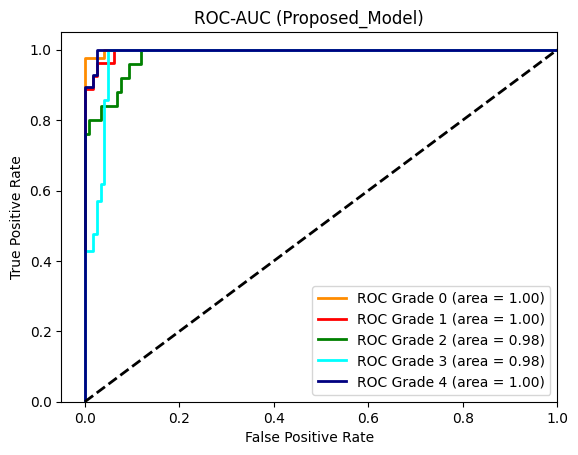

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score


import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
# from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle

fpr = dict()
tpr = dict()
roc_auc = dict()
lw=2
thresh ={}
for i in range(5):
    fpr[i], tpr[i], thresh[i] = roc_curve(test.labels, pred[:,i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['darkorange', 'red', 'green', 'aqua', 'navy'])
for i, color in zip(range(5), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC Grade {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC (Proposed Model)')
plt.legend(loc="lower right")
plt.savefig('D:/chanchal_NITK/TAI_Data/plot/KMC/proposed_ROC_AUC.png',bbox_inches='tight',dpi=300)
plt.show()

#Confusion Matrix

Confusion matrix, without normalization
[[40  1  0  0  0]
 [ 0 25  1  0  1]
 [ 1  1 20  3  0]
 [ 0  0  1 20  0]
 [ 0  0  0  3 25]]


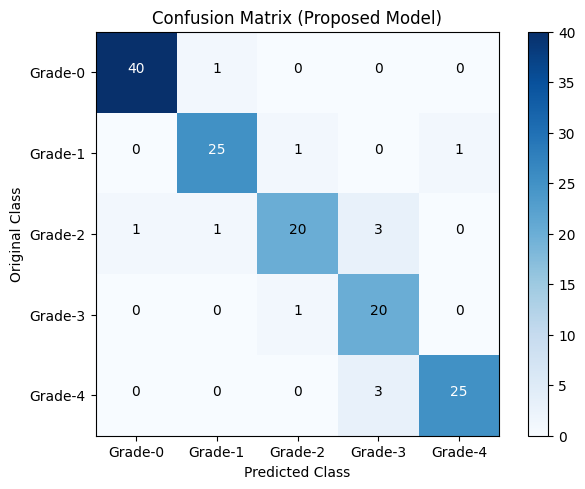

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
cm = confusion_matrix(y_true=test.labels, y_pred=pred_class_indices)
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
labels = [ "Grade-0","Grade-1","Grade-2","Grade-3","Grade-4"]  
plot_confusion_matrix(cm, labels,
                        normalize=False,
                        title='Confusion Matrix (Proposed Model)',
                        cmap=plt.cm.Blues)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
# plt.title("Confusion matrix")
plt.savefig('D:/chanchal_NITK/TAI_Data/plot/KMC/proposed_Confusion-Matrix-1.png',bbox_inches='tight',dpi=300)
plt.show()